# Gaussian process

- Multivariate normal distribution
- Gaussian process regressor
- Bayesian optimization

Note that the implementation has been optimized sufficiently.

In [1]:
from math import sin
from math import pi

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
from torch.nn.functional import softplus
from torch.distributions.multivariate_normal import MultivariateNormal

## Multivariate normal distribution

In [2]:
MultivariateNormal(torch.zeros(2), torch.eye(2)).log_prob(torch.Tensor([0, 0]))

tensor(-1.8379)

In [3]:
-MultivariateNormal(torch.zeros(2), torch.eye(2)).log_prob(torch.Tensor([1, 2]))

tensor(4.3379)

In [4]:
MultivariateNormal(torch.zeros(1), torch.eye(1)).log_prob(torch.Tensor([0]))

tensor(-0.9189)

In [5]:
np.log((1/(2*np.pi)**0.5))

-0.9189385332046727

In [6]:
np.log(norm().pdf(0))

-0.9189385332046727

## Gaussian process regressor

 - https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html

In [7]:
class GaussianProcessRegressor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._theta = torch.nn.Parameter(torch.Tensor([1.0, 1.0, 1.0]))
        self._beta = torch.nn.Parameter(torch.tensor(1.0))
        self.X = None
        self.t_centered = None
        self.t_original_center = None
        
    @property
    def theta(self):
        return softplus(self._theta)
    
    @property
    def beta(self):
        return softplus(self._beta)
        

    @staticmethod
    def _kernel(x1: torch.Tensor, x2: torch.Tensor, theta: torch.Tensor):
        d = x1 - x2
        return theta[0] * np.e ** (- (theta[1]/2) * (d.T @ d)) + theta[2]

    @classmethod
    def _build_K(cls, X, theta):
        return torch.stack(
            [torch.stack([cls._kernel(x1, x2, theta) for x2 in X]) for x1 in X]
        )

    def set_data(self, X, t):
        assert X.ndim == 2
        assert t.ndim == 2
        assert t.shape[1] == 1
        assert X.shape[0] == t.shape[0]
                                        
        n_rows = t.shape[0]
        self.t_original_center = t.mean()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.t_centered = torch.tensor(t - self.t_original_center, dtype=torch.float32)
        
    def forward(self, X_test, return_std=False):
        X_test = torch.Tensor(X_test)
        assert X_test.ndim == 2

        k = torch.Tensor(
            [[self._kernel(x_t, x, self.theta) for x_t in X_test] for x in self.X]
        )
        c = (
            torch.Tensor([[self._kernel(x_t, x_t, self.theta)] for x_t in X_test])
            + self.beta
        )

        K = self._build_K(self.X, self.theta)
        cov = K + torch.eye(K.shape[0]) * self.beta
        cov_inv = torch.inverse(cov)

        t_mean = k.T @ cov_inv @ self.t_centered + self.t_original_center
        t_var = c - torch.sum((k.T @ cov_inv).T * k, dim=0, keepdim=True).T
        
        thr = 0.0000001
        if (t_var < thr).sum() > 0:
            print(self.theta, self.beta)
        
        t_std = t_var ** 0.5

        if return_std:
            return t_mean, t_std

        return t_mean

    def fit(self, _X: np.ndarray, _t: np.ndarray):
        self.set_data(_X, _t)

        n_rows = self.t_centered.shape[0]
        last_loss = np.inf
        tolerance = 0

        self._theta = torch.nn.Parameter(torch.Tensor([1.0, 1.0, 1.0]))
        self._beta = torch.nn.Parameter(torch.tensor(1.0))

        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        for i in range(1000):
            optimizer.zero_grad()
            mean, std = self.forward(self.X, return_std=True)
            loss = -MultivariateNormal(mean.flatten(), torch.diag(std.flatten())).log_prob(
                self.t_centered.flatten()
            )
            loss.backward()
            optimizer.step()

            if i > 300:
                if last_loss - loss < 0.1:
                    if tolerance > 10:
                        break
                    else:
                        tolerance += 1
                else:
                    last_loss = loss
                    tolerance = 0

        print(f"n_rows={n_rows}, i={i}, loss={loss}")

    def predict(self, X_test, return_std=False):
        mean, std = self.forward(X_test, return_std=True)
        mean = mean.detach().numpy()

        if return_std:
            std = std.detach().numpy()
            return mean, std
        return mean
    
    def sample(self):
        n_rows = self.t_centered.shape[0]
        zero_mean = torch.zeros(n_rows)
        K = self._build_K(self.X, self.theta)
        cov_matrix = K + (1 / self.beta) * torch.eye(n_rows)
        return MultivariateNormal(zero_mean, cov_matrix).sample()

### Test

In [8]:
N = 100
def fun(x):
    return np.sin(X) * np.cos(X) ** 2
X = np.array([[float(5*i/N)] for i in range(N)])
T = fun(X)
T_mean = T.mean()
gpr = GaussianProcessRegressor()
gpr.X = torch.Tensor(X)
gpr.t_centered = torch.Tensor(T - T_mean)
gpr.t_original_center = T_mean

In [9]:
gpr.X.shape

torch.Size([100, 1])

In [10]:
gpr.predict(np.array([[3.5], [4.5]]), return_std=True)

(array([[-0.20805219],
        [-0.11772235]], dtype=float32),
 array([[1.173612 ],
        [1.1764145]], dtype=float32))

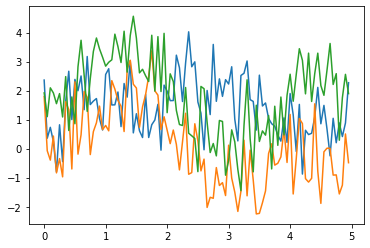

In [11]:
for i in range(3):
    samples = gpr.sample()
    plt.plot(X, samples)
plt.show()

## Bayesian optimization

In [12]:
def objective(x, noise=0.1):
    noise = np.random.normal(loc=0, scale=noise)
    return ((x - 1) ** 2 * sin(5 * pi * x) ** 6.0) + noise


def surrogate(model, X):
    return model.predict(X, return_std=True)


def acquisition(X, Xsamples, model):
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    mu, std = surrogate(model, Xsamples)
    probs = norm.cdf((mu - best) / (std + 1e-9))
    return probs


def opt_acquisition(X, y, model):
    Xsamples = np.random.random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    scores = acquisition(X, Xsamples, model)
    ix = np.argmax(scores)
    return Xsamples[ix, 0]


def plot(X, y, model):
    x_samples = np.asarray(np.arange(0, 1, 0.005)).reshape(-1, 1)
    y_samples, std_samples = surrogate(model, x_samples)

    x_samples = x_samples.squeeze()
    y_samples = y_samples.squeeze()
    std_samples = std_samples.squeeze()

    if True:
        fig, ax = plt.subplots()
        ax.scatter(X, y)
        ax.plot(x_samples, y_samples)
        ax.fill_between(
            x_samples,
            y_samples - std_samples,
            y_samples + std_samples,
            color="b",
            alpha=0.1,
        )
        plt.show()

n_rows=1, i=313, loss=0.5397660732269287


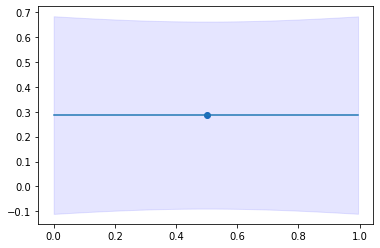

>x=0.536, f()=0.286329, actual=0.005
n_rows=2, i=313, loss=0.8722101449966431


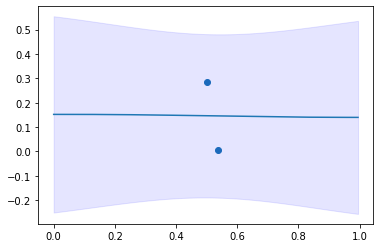

>x=0.082, f()=0.151887, actual=0.582
n_rows=3, i=313, loss=1.7070176601409912


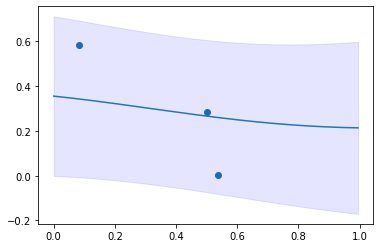

>x=0.003, f()=0.354924, actual=0.003
n_rows=4, i=313, loss=2.140437602996826


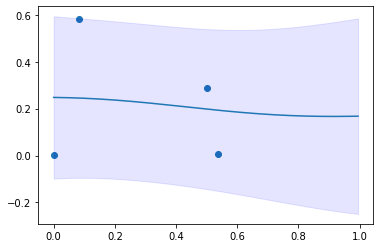

>x=0.005, f()=0.247813, actual=0.154
n_rows=5, i=360, loss=2.116633415222168


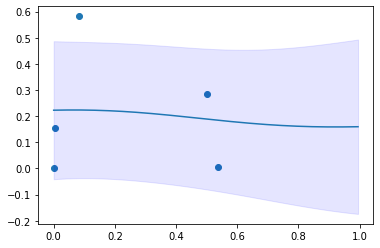

>x=0.065, f()=0.223579, actual=0.394
n_rows=6, i=378, loss=2.4932708740234375


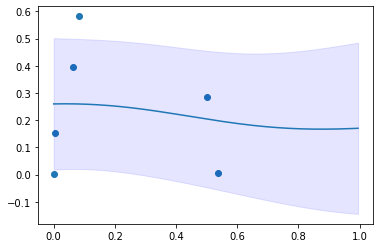

>x=0.040, f()=0.260301, actual=0.039
n_rows=7, i=440, loss=2.1106419563293457


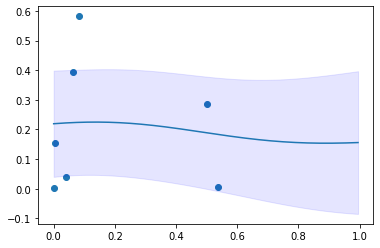

>x=0.135, f()=0.224998, actual=0.217
n_rows=8, i=473, loss=1.9902467727661133


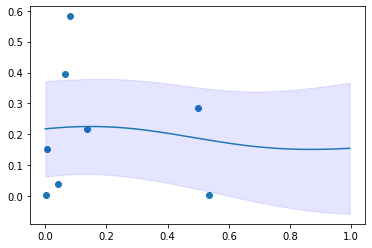

>x=0.164, f()=0.225610, actual=0.111
n_rows=9, i=506, loss=1.6973381042480469


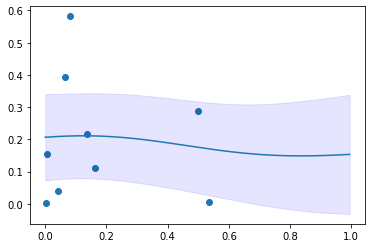

>x=0.126, f()=0.210881, actual=0.413
n_rows=10, i=490, loss=2.397144317626953


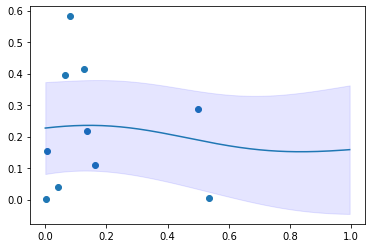

>x=0.139, f()=0.235484, actual=0.172
n_rows=11, i=522, loss=2.1480484008789062


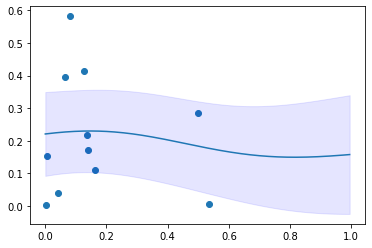

Best Result: x=0.082, y=0.582


In [13]:
X = np.random.random(1)
y = np.asarray([objective(x) for x in X])

X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)

model = GaussianProcessRegressor()
model.fit(X, y)
plot(X, y, model)

for i in range(10):
    x = opt_acquisition(X, y, model)
    actual = objective(x)
    est, _ = surrogate(model, [[x]])

    print(">x=%.3f, f()=%3f, actual=%.3f" % (x, est, actual))

    X = np.vstack((X, [[x]]))
    y = np.vstack((y, [[actual]]))

    model.fit(X, y)
    plot(X, y, model)

ix = np.argmax(y)
print("Best Result: x=%.3f, y=%.3f" % (X[ix], y[ix]))